In [3]:
# import numpy, pandas, sklearn for k-means and pca


import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import umap
import cv2

import keras
import collections

from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
#from sklearn.datasets import load_digits

In [4]:
# import the data from pickle
src = "./data/LSWMD.pkl"
data=pd.read_pickle(src)


# clean the label data as I would be using it for getting a subset
def clean(x):
    if(len(x) == 0):
        return ""
    else:
        return x[0][0]

def replacecolumn(column):
    newcolumn = []
    for entry in column:
        if(len(entry)==0):
            entry = ""
        else:
            entry = entry[0][0]
        newcolumn.append(entry)
    return newcolumn

collabel = replacecolumn(data["trianTestLabel"])
colfailuretype = replacecolumn(data["failureType"])

data["trianTestLabel"] = collabel
data["failureType"] = colfailuretype

# clean unlabeled data
print(data.shape)
data = data[data["failureType"] != ""]
print(data.shape)

(811457, 6)
(172950, 6)


In [5]:
# use the training data as using the whole data set is costly and results in kernel crash.
subdata = data[data['trianTestLabel'] == "Training"] #data cleaning of [["Training"]]-> "Training" needed

#check only defective ones as the defects are in one cluster
#subdata = subdata[data['failureType'] != "none"] #data cleaning of [["Training"]]-> "Training" needed

# fetch the wafer map and failure type
waferdata = subdata["waferMap"]
labelwaferdata = subdata["failureType"]

lb_make = LabelEncoder()
labelwaferdata = lb_make.fit_transform(labelwaferdata)
print(labelwaferdata[0])

# the idea is to have all the circular defects be close to the normal by making any defect at the edge to be rotated to be at the bottom
def rotationmax(wafer):
    rotationlist = []
    rotangle = 60 # having a degree of not 90 results in more empty space which can be resolved with 
    steps = 360//rotangle
    for i in range(steps):
        rotated = ndimage.rotate(wafer, rotangle*i, reshape=False)
        rotationlist.append(rotated)
    
    
    intensitylist = []
    for image in rotationlist:
        #3*(len(a)//4):len(a),:
        intensitysum = sum(sum(image[1*(size[1]//2):size[1],:]))
        intensitylist.append(intensitysum)
    
    idx = np.argmax(intensitylist)
    
    #print(len(rotationlist),idx,steps,intensitylist)

    newwafer = rotationlist[idx]
    
    return newwafer
    
# resize the wafer maps to be uniform

size = (51,51)
thresh = 1.5

newwaferdata = []
for idx,wafer in enumerate(waferdata):
    wafer = cv2.medianBlur(wafer, 5)
    wafer = cv2.medianBlur(wafer, 3)
    wafer = cv2.resize(wafer, dsize=size, interpolation=cv2.INTER_CUBIC)

    #wafer = cv2.medianBlur(wafer, 3)
    #wafer = rotationmax(wafer)
    wafer = cv2.threshold(wafer, thresh, 255, cv2.THRESH_BINARY)[1]    
    #print(wafer.shape)
    #wafer = np.array(wafer).reshape(size[0]*size[1])
    newwaferdata.append(wafer)

newwaferdata = np.array(newwaferdata)
print(newwaferdata.shape,newwaferdata[0].shape)
   
# rotations need to happen to every image as the label data isn't known.

8
(54355, 51, 51) (51, 51)


In [23]:
# the difference here is that instead of just having a flat vector, try using an autoencoder
from keras import layers

length = newwaferdata.shape[0]


flatnewwaferdata = newwaferdata.reshape((length,size[0]*size[1]))
inputshape = flatnewwaferdata[0].shape
print(inputshape)

encoding_dim = 32
input_img = keras.Input(shape=inputshape)
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(inputshape[0], activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


# encoder and decoder
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# compile
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print(autoencoder)

(2601,)


In [26]:
autoencoder.fit(flatnewwaferdata, flatnewwaferdata,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(flatnewwaferdata, flatnewwaferdata))


Train on 54355 samples, validate on 54355 samples
Epoch 1/50
54355/54355 [==============================] - 6s 118us/step - loss: -229776978.5783 - val_loss: -246014310.6448
Epoch 2/50
54355/54355 [==============================] - 6s 115us/step - loss: -262282012.3146 - val_loss: -279430049.2434
Epoch 3/50
54355/54355 [==============================] - 6s 116us/step - loss: -296643398.9263 - val_loss: -314513835.3717
Epoch 4/50
54355/54355 [==============================] - 6s 114us/step - loss: -332736731.9917 - val_loss: -351768196.6154
Epoch 5/50
54355/54355 [==============================] - 6s 118us/step - loss: -370399307.4724 - val_loss: -389879406.2634
Epoch 6/50
54355/54355 [==============================] - 6s 118us/step - loss: -409835858.2633 - val_loss: -430484450.7642
Epoch 7/50
54355/54355 [==============================] - 6s 116us/step - loss: -451000621.9674 - val_loss: -472192179.9794
Epoch 8/50
54355/54355 [==============================] - 6s 116us/step - loss: -4

In [27]:
reducedwaferdata = encoder.predict(flatnewwaferdata)

print(reducedwaferdata,reducedwaferdata.shape)
#print(umap)
model = umap.UMAP(
    n_neighbors=40,
    min_dist=0.0,
    n_components=2,
    random_state=42
)
umapdata = model.fit_transform(reducedwaferdata, y = labelwaferdata)
umapdata.astype("double")

[[15.4949465 15.484083  15.49147   ... 15.4955635 15.495813  15.491634 ]
 [15.4949465 15.484083  15.49147   ... 15.4955635 15.495813  15.491634 ]
 [15.4949465 15.484083  15.49147   ... 15.4955635 15.495813  15.491634 ]
 ...
 [15.4949465 15.484083  15.49147   ... 15.4955635 15.495813  15.491634 ]
 [15.4949465 15.484083  15.49147   ... 15.4955635 15.495813  15.491634 ]
 [15.4949465 15.484083  15.49147   ... 15.4955635 15.495813  15.491634 ]] (54355, 32)


/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([[ -0.48768967,  -9.11884689],
       [ -2.13687754, -10.97441959],
       [  0.46877658, -10.28687   ],
       ...,
       [ -2.5669632 , -10.42890263],
       [ -2.1523869 , -13.25657368],
       [ -2.08616662, -13.08420277]])

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
Counter({'black': 36730, 'green': 8554, 'red': 3462, 'yellow': 2417, 'blue': 1620, 'cyan': 609, 'purple': 500, 'orange': 409, 'lime': 54})
Counter({'none': 36730, 'Edge-Ring': 8554, 'Center': 3462, 'Edge-Loc': 2417, 'Loc': 1620, 'Random': 609, 'Scratch': 500, 'Donut': 409, 'Near-full': 54})


AttributeError: 'Line2D' object has no property 's'

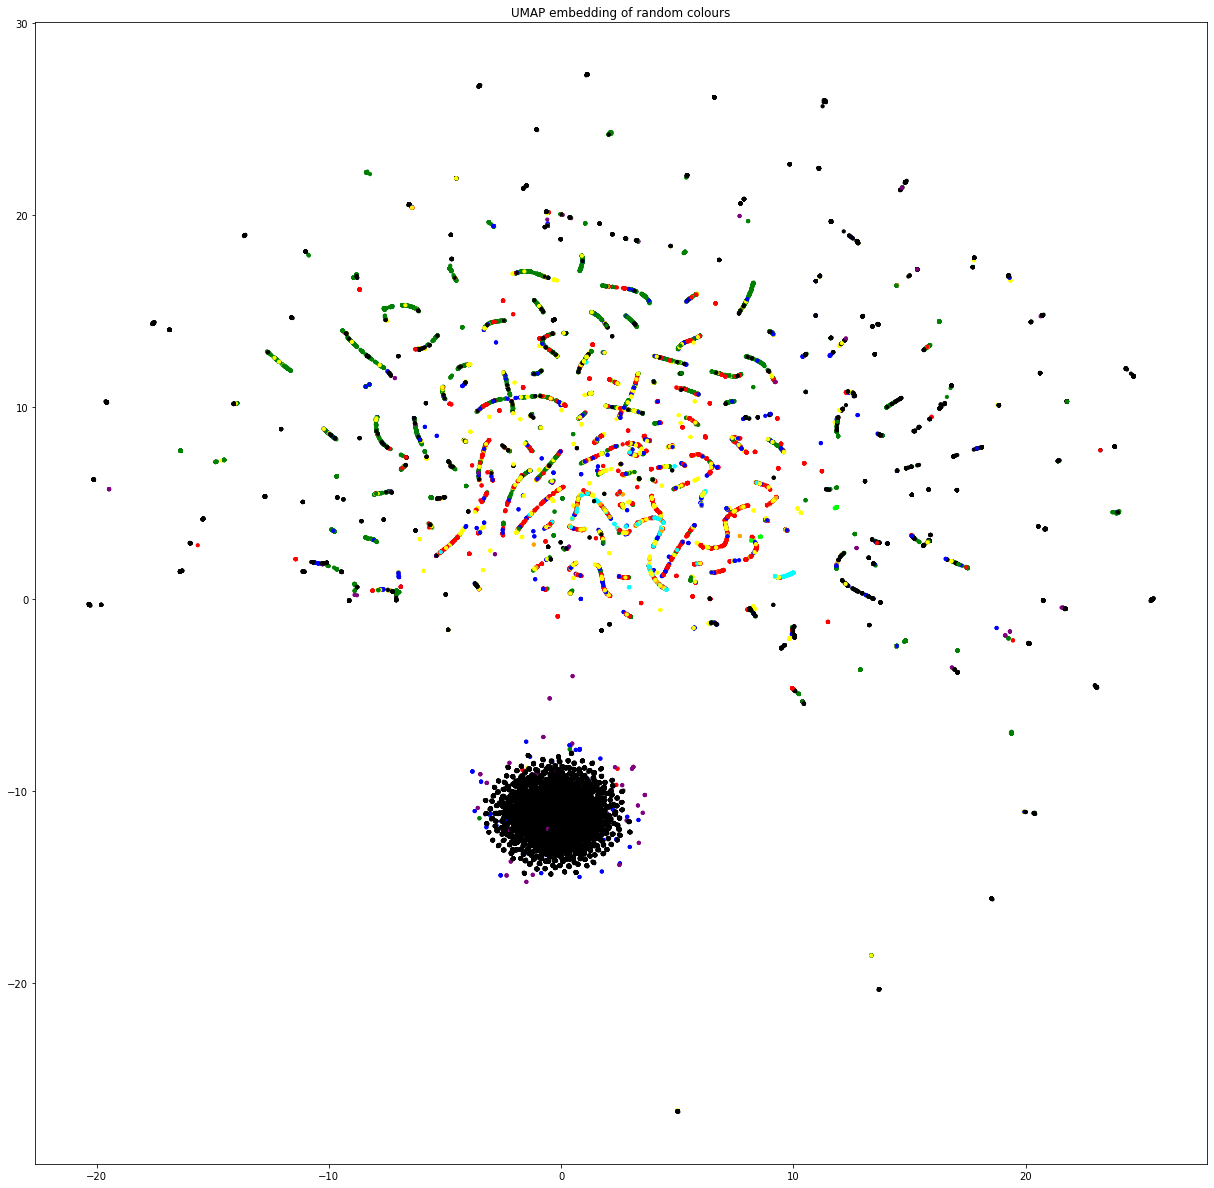

In [29]:
#Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.
import matplotlib.patches as mpatches

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full","none"]


colormap = {
    "Center"   : "red",
    "Donut"    : "orange",
    "Edge-Loc" : "yellow",
    "Edge-Ring": "green",
    "Loc"      : "blue",
    "Random"   : "cyan",
    "Scratch"  : "purple",
    "Near-full": "lime",
    "none"     : "black"
}

colors = subdata["failureType"].map(colormap)

#classes = list(set(lb_make.inverse_transform(labelwaferdata)))
print(classes)
print(collections.Counter(colors))
print(collections.Counter(subdata["failureType"]))


plt.figure(figsize=(21, 21))
scatter = plt.scatter(umapdata[:,0], umapdata[:,1], c=colors,s=10.1) #,label=str(classes))
plt.title('UMAP embedding of random colours')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='',s = 0.1) for color in colormap.values()]
plt.legend(markers, colormap.keys(), numpoints=1)

plt.show()